# Практическое задание

# Богданов Андрей, 192


### Задача Bike Sharing

Задача на kaggle: https://www.kaggle.com/c/bike-sharing-demand

По историческим данным о прокате велосипедов и погодных условиях необходимо спрогнозировтаь спрос на прокат велосипедов.

В исходной псотановке задачи доступно 9 признаков: https://www.kaggle.com/c/prudential-life-insurance-assessment/data

В наборе признаков присутсвуют вещественные, категориальные, и бинарные данные. 

### Анализ и визуализация данных

In [1]:
from sklearn import cross_validation, ensemble, grid_search, linear_model, metrics, pipeline, preprocessing

import numpy as np
import pandas as pd

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_csv('bike_sharing_train.csv')

In [4]:
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,1


3 . Проанализируйте описание данных:

***datetime*** - hourly date + timestamp  

***season*** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

***holiday*** - whether the day is considered a holiday

***workingday*** - whether the day is neither a weekend nor holiday

***weather*** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    
***temp*** - temperature in Celsius

***atemp*** - "feels like" temperature in Celsius

***humidity*** - relative humidity

***windspeed*** - wind speed

***count*** - number of total rentals

Было бы логично, что погода(weather), atemp, season

Может влажность, время.

Преобразуем дату в 4 признака - год, месяц, день, час

In [5]:
def date_to_year(string):
    return int(string[0:4])

def date_to_month(string):
    return int(string[5:7])

def date_to_day(string):
    return int(string[8:10])
def date_to_hour(string):
    return int(string[11:13])

In [6]:
data['year']=data.datetime.map(date_to_year)
data['month']=data.datetime.map(date_to_month)
data['day']=data.datetime.map(date_to_day)
data['hour']=data.datetime.map(date_to_hour)
data.drop('datetime', axis=1, inplace=True)

In [7]:
features = data.columns.drop(["count"]).tolist()
answer = ["count"]

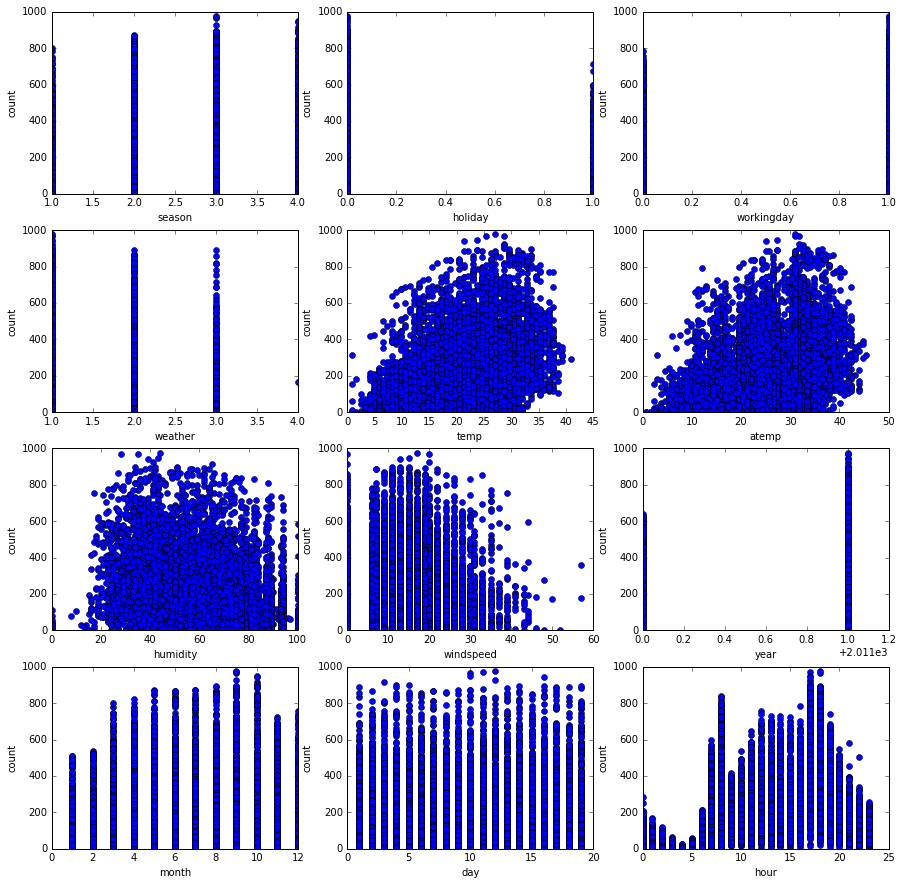

In [8]:
from matplotlib import pylab as plt
fig = plt.figure(figsize=(15,15))
for i in range(len(features)):
    plt.subplot(4, 3, i + 1,)
    plt.xlabel(features[i])
    plt.ylabel('count')
    plt.plot(data[features[i]], data[answer],'o')


В 2012 году, прокат пользовался большим спросом,в 8 утра и в 5-6 вечера тоже, с марта по октябрь, в непраздничные рабочие дни.

In [9]:
data.corrwith(data['count'])

season        0.163439
holiday      -0.005393
workingday    0.011594
weather      -0.128655
temp          0.394454
atemp         0.389784
humidity     -0.317371
windspeed     0.101369
count         1.000000
year          0.260403
month         0.166862
day           0.019826
hour          0.400601
dtype: float64

In [10]:
data.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.163439,-0.004797,0.971524,0.001729,-0.006546
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,-0.005393,0.012021,0.001731,-0.015877,-0.000354
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,0.011594,-0.002482,-0.003394,0.009829,0.002780
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.128655,-0.012548,0.012144,-0.007890,-0.022740
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.394454,0.061226,0.257589,0.015551,0.145430
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.389784,0.058540,0.264173,0.011866,0.140343
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.317371,-0.078606,0.204537,-0.011335,-0.278011
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.101369,-0.015221,-0.150192,0.036157,0.146631
count,0.163439,-0.005393,0.011594,-0.128655,0.394454,0.389784,-0.317371,0.101369,1.000000,0.260403,0.166862,0.019826,0.400601
year,-0.004797,0.012021,-0.002482,-0.012548,0.061226,0.058540,-0.078606,-0.015221,0.260403,1.000000,-0.004932,0.001800,-0.004234


Сильно коррелирует время года и месяц, ощущаемая температура и температура, температура и ответ(кол-во)

In [11]:
print ("Средние значения")
print data.mean()
print ("\n\nОтклонения")
print data.std()


Средние значения
season           2.506614
holiday          0.028569
workingday       0.680875
weather          1.418427
temp            20.230860
atemp           23.655084
humidity        61.886460
windspeed       12.799395
count          191.574132
year          2011.501929
month            6.521495
day              9.992559
hour            11.541613
dtype: float64


Отклонения
season          1.116174
holiday         0.166599
workingday      0.466159
weather         0.633839
temp            7.791590
atemp           8.474601
humidity       19.245033
windspeed       8.164537
count         181.144454
year            0.500019
month           3.444373
day             5.476608
hour            6.915838
dtype: float64


Очевидно, что отличаются масштабы (год -2011, праздник - 0.02, температура - 20, кол-во отдаваемое в аренду - 191), это может привести к тому что, обучение модели может быть затруднено.

### Линейные модели

In [12]:
X = data.drop('count', axis=1) 
y = data["count"]
l = len(X) 
X_train = X[:int(l * 0.75)] 
y_train = y[:int(l * 0.75)]
X_test = X[int(l * 0.75):]
y_test = y[int(l * 0.75):]

In [13]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [14]:
from sklearn.linear_model import SGDRegressor, Lasso
from sklearn.metrics import mean_absolute_error

sgd = SGDRegressor()
sgd.fit(X_train, y_train)

lasso = Lasso()
lasso.fit(X_train, y_train)

y_sgd = sgd.predict(X_test)
y_lasso = lasso.predict(X_test)

print (mean_absolute_error(y_train, sgd.predict(X_train)))
print (mean_absolute_error(y_train, lasso.predict(X_train)))

print (mean_absolute_error(y_test, y_sgd))
print (mean_absolute_error(y_test, y_lasso))

94.031553917
93.7598229612
139.785251186
140.574295413


In [30]:
print "Coefficients for sgd \n"
zip(features, sgd.coef_)

Coefficients for sgd 



[('season', 3.0980369020067831),
 ('holiday', -5.2170045711198609),
 ('workingday', -3.9473828527824826),
 ('weather', -2.5726591285751361),
 ('temp', 21.150506613940554),
 ('atemp', 36.075142863883634),
 ('humidity', -33.051581607467241),
 ('windspeed', 2.5074197857284366),
 ('year', 43.094078792148615),
 ('month', 18.497743672880013),
 ('day', 3.8159855723433211),
 ('hour', 48.771088591142338)]

In [32]:
print "coefficients for lasso \n"
zip(features, lasso.coef_)

coefficients for lasso 



[('season', 0.0),
 ('holiday', -0.82149969199507955),
 ('workingday', -1.1393851806867679),
 ('weather', -5.1569755432627753),
 ('temp', 0.0),
 ('atemp', 53.758802321967451),
 ('humidity', -31.467391253505113),
 ('windspeed', 3.4549365442574245),
 ('year', 40.070327425154176),
 ('month', 20.537966516645863),
 ('day', 0.0),
 ('hour', 46.177219456769492)]

In [45]:
data['multiple1'] = data['temp'] * data['year']
data['multiple2'] = data['season'] * data['weather']
data['multiple3'] = data['year'] * data['month'] * data['day'] * data['hour']

In [48]:
features = data.columns.drop(["count"]).tolist() #Обновим фичи

In [51]:
X = data.drop('count', axis=1) 
y = data["count"]
l = len(X) 
X_train = X[:int(l * 0.75)] 
y_train = y[:int(l * 0.75)]
X_test = X[int(l * 0.75):]
y_test = y[int(l * 0.75):]

X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)


sgd = SGDRegressor()
sgd.fit(X_train, y_train)


y_sgd = sgd.predict(X_test)

print (mean_absolute_error(y_train, sgd.predict(X_train)))
print (mean_absolute_error(y_test, y_sgd))

print "Coefficients for sgd "
zip(features, sgd.coef_)


94.049239203
140.025026565
Coefficients for sgd 


[('season', 9.6168420487680262),
 ('holiday', -2.8218030765031323),
 ('workingday', -1.2425956685623412),
 ('weather', 0.95614007794423239),
 ('temp', 11.468086511576143),
 ('atemp', 30.688971395648355),
 ('humidity', -29.532259354824873),
 ('windspeed', 3.5810601264476056),
 ('year', 40.612263751129206),
 ('month', 17.272908172771711),
 ('day', -0.68350628490455179),
 ('hour', 40.914322271199367),
 ('multiple1', 11.629315118928686),
 ('multiple2', -8.1668158984486201),
 ('multiple3', 9.4899864779839991)]

In [106]:
# data.drop('multiple3', inplace=True , axis=1)
X = data.drop('count', axis=1)
y = data['count']
y = pd.DataFrame(y)
train_size = int(0.75 * len(X))
test_size = int(0.25 * len(X))
X_train = X.head(train_size)
y_train = y.head(train_size)

X_test = X.tail(test_size)
y_test = y.tail(test_size)

In [116]:
# Пример:
# train_data, train_labels - DataFrame с обучающей выборкой и значения целевой функции на обучении
# test_data, test_labels - DataFrame с тестовой выборкой и значения целевой функции на тесте
train_data = X_train
train_labels = y_train
test_data = X_test
test_labels = y_test
# Создание индекса для бинарных признаков
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'season', 'weather']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

# Создание модели регресии
model = linear_model.SGDRegressor(random_state = 0)

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


153.86381904156465

In [184]:
# Создание индекса для бинарных признаков
binary_data_columns = ['holiday', 'workingday']
binary_data_indices = np.array([(column in binary_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для вещественных признаков
numeric_data_columns = ['temp', 'atemp', 'humidity', 'windspeed']
numeric_data_indices = np.array([(column in numeric_data_columns) for column in train_data.columns], dtype = bool)

# Создание индекса для категориальных признаков
categorical_data_columns = ['year', 'month', 'day', 'hour', 'season', 'weather']
categorical_data_indices = np.array([(column in categorical_data_columns) for column in train_data.columns], dtype = bool)

# Создание модели регресии
model = linear_model.SGDRegressor(random_state = 0)

# Объявление pipline -  цепочки преобразования данных, начиная от обработки данных в зависимости от их типа, и 
# заканчивая обучением модели. 

estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))
                            ]))
    

        ])),
    ('model_fitting', model)
    ]
)

# С цепочкой можно работать как с одиночным преобразованием, в частности вызывать методы fit и predict 
estimator.fit(train_data, train_labels)
metrics.mean_absolute_error(test_labels, estimator.predict(test_data))

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


112.36428674671612

Немного улучшила качество, но оно все равно не очень хорошее

In [169]:
estimator.get_params().keys()

['feature_processing__binary_variables_processing__pass_y',
 'feature_processing__binary_variables_processing__func',
 'model_fitting__learning_rate',
 'feature_processing__n_jobs',
 'feature_processing__numeric_variables_processing__selecting',
 'feature_processing__numeric_variables_processing__scaling__with_std',
 'feature_processing__categorical_variables_processing__selecting__pass_y',
 'feature_processing__categorical_variables_processing__selecting__accept_sparse',
 'feature_processing__transformer_weights',
 'feature_processing__categorical_variables_processing__encoding__dtype',
 'model_fitting__fit_intercept',
 'feature_processing',
 'model_fitting__l1_ratio',
 'feature_processing__categorical_variables_processing__selecting__validate',
 'feature_processing__transformer_list',
 'feature_processing__numeric_variables_processing__steps',
 'model_fitting__warm_start',
 'model_fitting__random_state',
 'feature_processing__numeric_variables_processing__selecting__accept_sparse',
 

In [170]:
parameters_grid = { 
    'model_fitting__loss' : ['huber',  'epsilon_insensitive', 'squared_loss', ],
    'model_fitting__n_iter' :[3,5,10,50],
    'model_fitting__penalty' : ['l1', 'l2', 'none'],
    'model_fitting__alpha' : [0.0001, 0.01],
    'feature_processing__numeric_variables_processing__scaling__with_mean' : [0., 0.5]
}

In [185]:
grid_cv = grid_search.GridSearchCV(estimator, parameters_grid, scoring='mean_absolute_error', cv=4)

In [172]:
grid_cv.fit(train_data, train_labels)

C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda2\lib\site-packages\sklearn\utils\validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y,

GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000000106EBDD8>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(...r=5, penalty='l2', power_t=0.25,
       random_state=0, shuffle=True, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'feature_processing__numeric_variables_processing__scaling__with_mean': [0.0, 0.5], 'model_fitting__penalty': ['l1', 'l2', 'none'], 'model_fitting__n_iter': [3, 5, 10, 50], 'model_fitting__alpha': [0.0001, 0.01], 'model_fitting__loss': ['huber', 'epsilon_insensitive', 'squared_loss']},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

In [174]:
print grid_cv.best_score_
print grid_cv.best_params_

-72.5712170009
{'model_fitting__penalty': 'l1', 'model_fitting__alpha': 0.01, 'feature_processing__numeric_variables_processing__scaling__with_mean': 0.5, 'model_fitting__n_iter': 50, 'model_fitting__loss': 'squared_loss'}


In [175]:
grid_cv.best_score_

-72.571217000946191

Улучшил!

In [181]:
test_predictions = grid_cv.best_estimator_.predict(test_data)

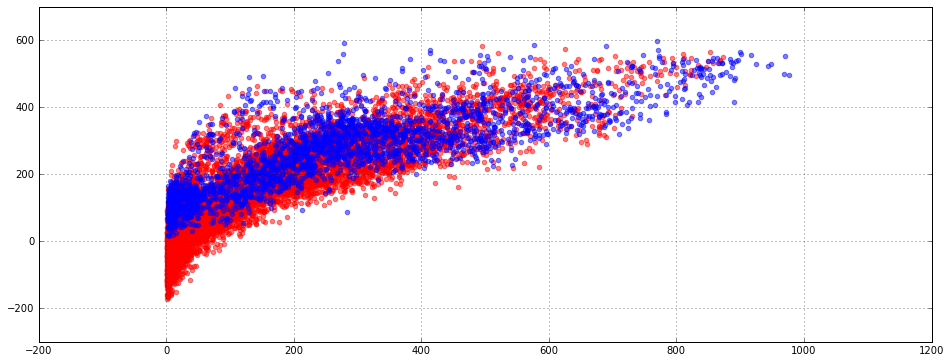

In [183]:
pylab.figure(figsize=(16,6))
pylab.grid(True)
pylab.scatter(train_labels, grid_cv.best_estimator_.predict(train_data), alpha=0.5, color= 'red')
pylab.scatter(test_labels, grid_cv.best_estimator_.predict(test_data), alpha=0.5, color= 'blue')

Хотим, чтобы облако было на диагонали, у нас конечно не совсем так, но болеее менее.

### Случайный лес

In [190]:
regressor = ensemble.RandomForestRegressor()
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [        
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])), 
                    
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler())            
                        ])),
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('encoding', preprocessing.OneHotEncoder(handle_unknown='ignore'))
                            ]))
    

        ])),
    ('model_fitting', regressor)
    ]
)

In [191]:
estimator.fit(train_data, train_labels)

C:\Anaconda2\lib\site-packages\sklearn\pipeline.py:165: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.steps[-1][-1].fit(Xt, y, **fit_params)


Pipeline(steps=[('feature_processing', FeatureUnion(n_jobs=1,
       transformer_list=[('binary_variables_processing', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x00000000109EB588>, pass_y=False,
          validate=True)), ('numeric_variables_processing', Pipeline(steps=[(...timators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [192]:
mean_absolute_error(test_labels, estimator.predict(test_data))

77.593495038588756

In [200]:
importances =  regressor.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range (train_data.shape[1]):
    print (" feature %d (%f)" % (indices[f], importances[indices[f]]))

 feature 3 (0.182354)
 feature 1 (0.091866)
 feature 64 (0.089993)
 feature 4 (0.080668)
 feature 65 (0.079396)
 feature 55 (0.055670)
 feature 2 (0.052079)
 feature 15 (0.042283)
 feature 14 (0.039508)
 feature 66 (0.029478)
 feature 54 (0.017772)
 feature 5 (0.016597)


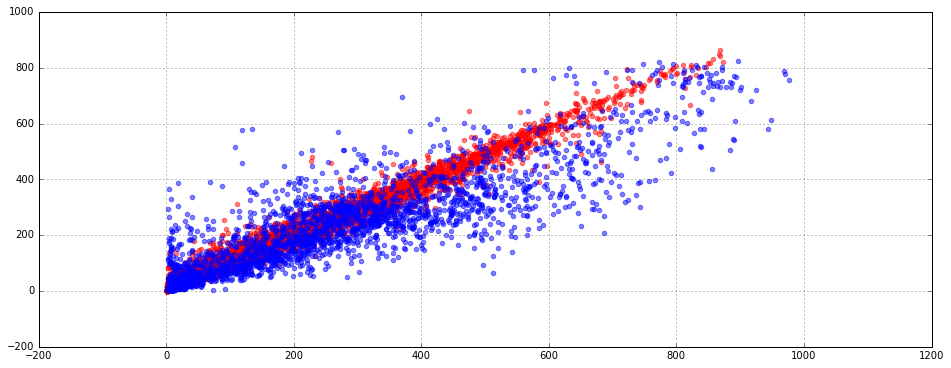

In [204]:
pylab.figure(figsize=(16,6))
pylab.grid(True)
pylab.scatter(train_labels, estimator.predict(train_data), alpha=0.5, color= 'red')
pylab.scatter(test_labels, estimator.predict(test_data), alpha=0.5, color= 'blue')

Этот лучше, ближе к диагонали находится

### Опциональная часть

Попробуйте улучшить результат, полученный на предыдущих шагах. В этом разделе можно и нужно пользоваться любыми изученными алгоритмами, инструментами и всем, чем вам захочется.

### Заключение

В этом разделе Вы можете написать, какие выводы Вы сделали в процессе работы над заданием, понравилось ли оно Вам, а также всё, что Вы о задании думаете =)

Хорошее задание, но поиск параметров по сетке без курсеры бы не сделал точно.